# Assignment 4

### Samuel Sheehy (Student ID 18143565)

### Techniques of High Performance Computing (PHAS0102)

### MSc Scientific Computing, University College London, 2019-2020

**This Jupyter Notebook is submitted as completion of the 4th Assignment for the UCL course cited above.**

## Setup

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from math import ceil

In [2]:
# Discretise

# Numerical Scheme

# Check results

* Finite difference method:
$$
u_h(t, x, y) = u_h(t - \tau, x, y) -  \frac{\tau}{h^2} \left[ 4 u_h(t - \tau, x, y)
- u_h(t - \tau, x - h, y) - u_h(t - \tau, x + h, y) - u_h(t - \tau, x, y - h) - u_h(t - \tau, x, y + h) \right]
$$

In [3]:
# Explicit Method

# Build matrix A
def is_bc(i, j, M):
    """
    Check if the given coordinates correspond to a boundary.
    """
    if i == 0 or i == M - 1:
        return True
    elif j == 0 or j == M - 1:
        return True
    else:
        return False
    
def build_explicit_system(tau, h0):
    """
    Build a matrix which applies an explicit method to solve the problem.
    """
    data = []
    rows = []
    cols = []
    
    M = ceil(2/h0)
    if M % 2 == 0:
        M += 1
        
    
    h = 2/M
    
#     print(f'h:{h}, h0:{h0}, tau:{tau}, M:{M}, C:{tau/h**2}')
    
    Mop = (M-2)**2
    
    
    b = np.zeros(Mop)
    
    def add(val, row, colshift):
        """
        Add coefficient to operator.
        """
        data.append(val)
        rows.append(row)
        if row+colshift < 0:
            raise Exception(f'Negative col index {row}: {colshift}')
        cols.append(row+colshift)
    
    k = 0
    for row_idx in range(1, M-1):
        for col_idx in range(1, M-1):
            # k = M * (row_idx - 1) + (col_idx - 1)
            # print(f'k: {k} = {row_idx} + {col_idx}')
            
            # Consider Boundary influences
            if is_bc(row_idx + 1, col_idx, M):
#                 print('top')
                b[k] += 0 #boundary_f((row_idx + 1)/M, col_idx/M)
                
            if is_bc(row_idx - 1, col_idx, M):
#                 print('bottom')
                b[k] += 5*tau/h**2 #boundary_f((row_idx - 1)/M, col_idx/M)
                
            if is_bc(row_idx, col_idx + 1, M):
#                 print('right')
                b[k] += 0 #boundary_f(row_idx, (col_idx + 1)/M)
                
            if is_bc(row_idx, col_idx - 1, M):
#                 print('left')                
                b[k] += 0 #boundary_f(row_idx, (col_idx - 1)/M)
            
            # Matrix
            if is_bc(row_idx, col_idx, M):
                raise Exception('Adding a bc to matrix')
            
            # center
            add(1 - 4*tau/h**2, k, 0)
#             add(4, k, 0)
            
            # left
            if col_idx >= 2:
                add(tau/h**2, k, -1)
#                 add(-1, k, -1)
            
            # right
            if col_idx < M - 2:
                add(tau/h**2, k, 1)
#                 add(-1, k, 1)
            
            # top
            if row_idx < M - 2:
                add(tau/h**2, k, M - 2)
#                 add(-1, k, M-2)
            
            # bottom
            if row_idx >= 2:
                add(tau/h**2, k, -(M - 2))
#                 add(-1, k, -M+2)
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        print(cols)
        raise Exception('Negative column index')

    A = coo_matrix((data, (rows, cols))).tocsc()
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        print('shape:', A.shape)
        return A, b
        raise Exception(f'Matrix is not square: {A.shape}')
    
    # Ensure it's the expected size
    if A.shape[0] != Mop:
        raise Exception(f'Matrix wrong size:{A.shape[0]}')
                
    return A, b


def show(b, M):
    p = b.reshape(M, M)
    p = np.pad(p, 1)

    # left bc
    p[:, 0] = 0

    # right bc
    p[:, -1] = 0

    # top bc
    p[-1, :] = 0

    # bottom bc
    p[0, :] = 5

    plt.imshow(p, origin='lower')
    plt.colorbar()
    plt.show()

In [25]:
# Boundaries:
def f(y, x):
    if y == 0: return 5
    else: return 0

h = 0.2
Tf = 0.41885# 0.424
nt = ceil(4*Tf)*ceil(1/(h)**2)

tau = Tf/nt
print(nt)

A, bounds = build_explicit_system(tau, h)

50


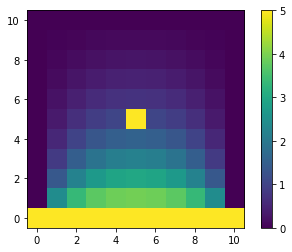

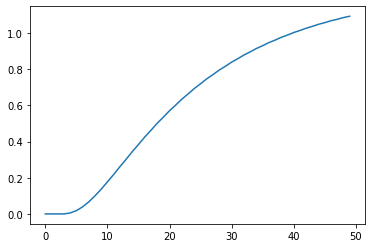

t:4.188500E-01 => center:5.0


In [31]:
b = np.empty_like(bounds)*0
iters = 0

t = 0
loc = len(b)//2

vals = []

for i in range(nt):
    t += tau
    b = A @ b + bounds
    vals.append(b[loc])

M = int(len(b)**0.5) + 2

b[loc] = 5

show(b, M - 2)
plt.plot(vals)
plt.show()
print(f't:{t:6E} => center:{b[loc]}')


In [34]:
# Center search

def f(t, h):
    nt = ceil(4*t)*ceil(1/(h)**2)
    tau = t/nt
    
    A, bounds = build_explicit_system(tau, h)
    b = np.empty_like(bounds)*0

    loc = len(b)//2

    vals = []

    for i in range(nt):
        b = A @ b + bounds
        vals.append(b[loc])
    
    return b[loc] #, vals


def richardson(t, h):
    uh = f(t, h)
    u2h = f(t, h/2)
    return  uh + (uh - u2h)/3


g = lambda t, h: richardson(t, h) - 1


def secant(u0, u1, f, tol, maxiter=1000):
    u_2= u1
    u_1 = u0
    k = 0
    h = 1/64
    while u_2 - u_1 > tol and k < maxiter:
        f2 = g(u_2, h)
        f1 = g(u_1, h)
        u_new = u_2 - f2*(u_2 - u_1)/(f2 - f1)
        u_1 = u_2
        u_2 = u_new
        print(u_new)
        k += 1
    if k == maxiter:
        print('max iters achieved', k)
    return u_2

secant(0.3, 0.4, g, 1e-4, 10)

0.4120883569585803
0.4161426946916189
0.41631050124853647
0.4163122883054214


0.4163122883054214

In [16]:
f()

1.027803747449141

In [ ]:
# Crank-Nicholson Method

def build_CN_system(tau, h0):
    """
    Build a matrix which applies an explicit method to solve the problem.
    """
    data = []
    rows = []
    cols = []
    
    M = ceil(2/h0)
    if M % 2 == 0:
        M += 1
        
    
    h = 2/M
    
#     print(f'h:{h}, h0:{h0}, tau:{tau}, M:{M}, C:{tau/h**2}')
    
    Mop = (M-2)**2
    
    
    b = np.zeros(Mop)
    
    def add(val, row, colshift):
        """
        Add coefficient to operator.
        """
        data.append(val)
        rows.append(row)
        if row+colshift < 0:
            raise Exception(f'Negative col index {row}: {colshift}')
        cols.append(row+colshift)
    
    k = 0
    for row_idx in range(1, M-1):
        for col_idx in range(1, M-1):
            # k = M * (row_idx - 1) + (col_idx - 1)
            # print(f'k: {k} = {row_idx} + {col_idx}')
            
            # Consider Boundary influences
            if is_bc(row_idx + 1, col_idx, M):
#                 print('top')
                b[k] += 0 #boundary_f((row_idx + 1)/M, col_idx/M)
                
            if is_bc(row_idx - 1, col_idx, M):
#                 print('bottom')
                b[k] += 5*tau/h**2 #boundary_f((row_idx - 1)/M, col_idx/M)
                
            if is_bc(row_idx, col_idx + 1, M):
#                 print('right')
                b[k] += 0 #boundary_f(row_idx, (col_idx + 1)/M)
                
            if is_bc(row_idx, col_idx - 1, M):
#                 print('left')                
                b[k] += 0 #boundary_f(row_idx, (col_idx - 1)/M)
            
            # Matrix
            if is_bc(row_idx, col_idx, M):
                raise Exception('Adding a bc to matrix - not correct')
            
            # center
            add(1 - 4*tau/h**2, k, 0)
#             add(4, k, 0)
            
            # left
            if col_idx >= 2:
                add(tau/h**2, k, -1)
#                 add(-1, k, -1)
            
            # right
            if col_idx < M - 2:
                add(tau/h**2, k, 1)
#                 add(-1, k, 1)
            
            # top
            if row_idx < M - 2:
                add(tau/h**2, k, M - 2)
#                 add(-1, k, M-2)
            
            # bottom
            if row_idx >= 2:
                add(tau/h**2, k, -(M - 2))
#                 add(-1, k, -M+2)
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        print(cols)
        raise Exception('Negative column index')

    A = coo_matrix((data, (rows, cols))).tocsc()
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        print('shape:', A.shape)
        return A, b
        raise Exception(f'Matrix is not square: {A.shape}')
    
    # Ensure it's the expected size
    if A.shape[0] != Mop:
        raise Exception(f'Matrix wrong size:{A.shape[0]}')
                
    return A, b